In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# variable
f = 100e3
time_interval = 1/f
tau = 0
pc = 0


In [3]:
# loran-c 300
t = np.linspace(0, 300, 30000)

envelope = (t-tau)**2*np.exp(-2*(t-tau)/65)
normalized_e = (envelope - np.min(envelope))/(np.max(envelope)-np.min(envelope))
s = normalized_e *np.sin(2*np.pi*f*t*1e-6 + pc)

In [4]:
# Loran-c 300 fft
N = len(s)
k = np.arange(N)
T = N/f
freq = k / T
freq = freq[range(int(N/2))]

s_fft = np.fft.fft(s)
sf = s_fft / N
sf = sf[range(int(N/2))]

sf = abs(sf)
normalized_sf = (sf - np.min(sf)) / (np.max(sf) - np.min(sf))


In [5]:

# loran-c 1000
t_2 = np.linspace(0, 1000, 30000)

envelope_2 = (t_2-tau)**2*np.exp(-2*(t_2-tau)/65)
normalized_e_2 = (envelope_2 - np.min(envelope_2))/(np.max(envelope_2)-np.min(envelope_2))
s_2 = normalized_e_2 *np.sin(2*np.pi*f*t_2*1e-6 + pc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


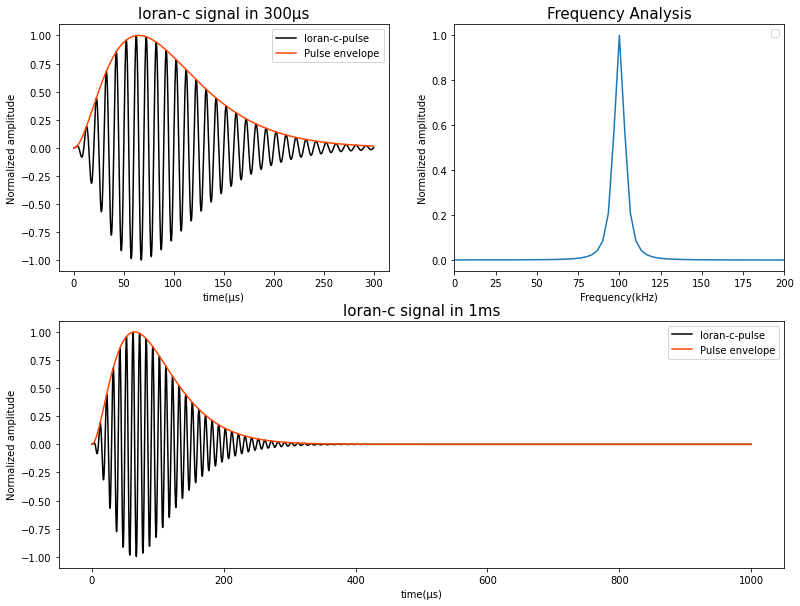

In [6]:
fig = plt.figure(figsize=(13, 10))

ax1 = plt.subplot2grid((2,2), 
                       (0,0), 
                       fig=fig)

ax2 = plt.subplot2grid((2,2), 
                       (0,1), 
                       fig=fig)

ax3 = plt.subplot2grid((2, 2),
                       (1, 0),
                       colspan=2,
                       fig=fig)

ax1.plot(t, s, 'k', label='loran-c-pulse')
ax1.plot(t, normalized_e, 'orangered', label='Pulse envelope')
ax1.set_title("loran-c signal in 300μs", fontsize=15)
ax1.set_ylabel("Normalized amplitude", fontsize=10)
ax1.set_xlabel("time(μs)", fontsize=10)
ax1.legend()

ax2.plot(freq[:200], abs(normalized_sf[:200]))
ax2.set_xlim(0, 200)
ax2.set_title("Frequency Analysis", fontsize=15)
ax2.set_ylabel("Normalized amplitude", fontsize=10)
ax2.set_xlabel("Frequency(kHz)", fontsize=10)
ax2.legend()

ax3.plot(t_2, s_2, 'k', label='loran-c-pulse')
ax3.plot(t_2, normalized_e_2, 'orangered', label='Pulse envelope')
ax3.set_title('loran-c signal in 1ms', fontsize=15)
ax3.set_ylabel("Normalized amplitude", fontsize=10)
ax3.set_xlabel("time(μs)", fontsize=10)
ax3.legend()

plt.show()

#### master window / slave window
`master_window()`에서는 master의 reference signal을 생성한다. tau값을 증가시키면서 총 10ms(10,000μs)의 reference signal을 생성한다.
생성을 완료한 후에는 현재는 생성된 신호를 ploting하고, reference signal을 return 함.

In [7]:
def gen_master_window():
    
    freq = 100e3
    tau = 0
    master_window = np.array([])
    master_window_e = np.array([])
    timespace = np.array([])

    for i in range(0, 10):
        
        t = np.linspace(tau, tau+1000, 30000)
        
        if i == 8:
            normalized_e = np.zeros(shape=(30000, ))
            s = np.zeros(shape=(30000, ))
        
        else:
            envelope = (t-tau)**2*np.exp(-2*(t-tau)/65)
            normalized_e = (envelope - np.min(envelope))/(np.max(envelope)-np.min(envelope))
            s = normalized_e *np.sin(2*np.pi*f*t*1e-6 + pc)
        
        timespace = np.append(timespace[:-1], t)
        master_window = np.append(master_window[:-1], s)
        master_window_e = np.append(master_window_e[:-1], normalized_e)
        
        #print("tau :", tau)
        #print("length of time space :", len(timespace))
        #print("length of master_window :", len(master_window))
        #print("length of master_window_e :", len(master_window_e))
        
        tau += 1000
        
    return timespace, master_window, master_window_e
        

In [8]:
timespace_m, master_window, master_window_e = gen_master_window()

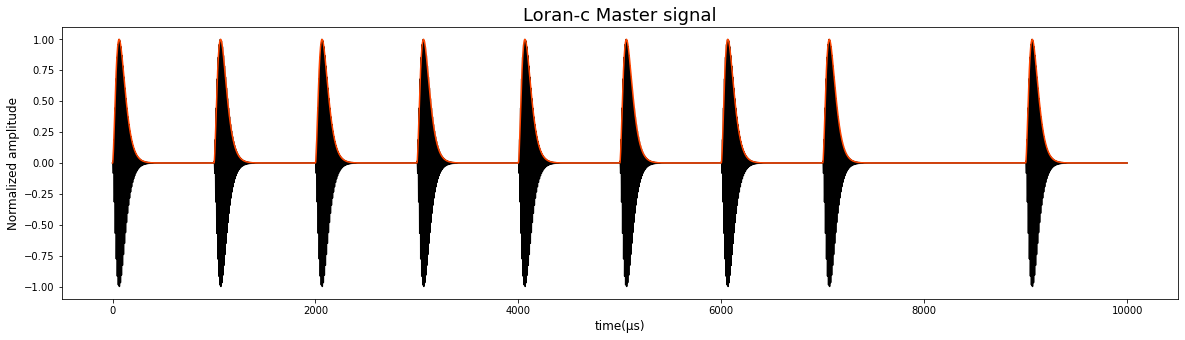

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(timespace_m, master_window, 'k')
plt.plot(timespace_m, master_window_e, 'orangered')
plt.title("Loran-c Master signal", fontsize=18)
plt.xlabel("time(μs)", fontsize=12)
plt.ylabel("Normalized amplitude", fontsize=12)
plt.show()

In [10]:
def gen_slave_window():
    freq = 100e3
    tau = 0
    slave_window = np.array([])
    slave_window_e = np.array([])
    timespace = np.array([])

    for i in range(0, 8):
        
        t = np.linspace(tau, tau+1000, 30000)
 
        envelope = (t-tau)**2*np.exp(-2*(t-tau)/65)
        normalized_e = (envelope - np.min(envelope))/(np.max(envelope)-np.min(envelope))
        s = normalized_e *np.sin(2*np.pi*f*t*1e-6 + pc)
        
        timespace = np.append(timespace[:-1], t)
        slave_window = np.append(slave_window[:-1], s)
        slave_window_e = np.append(slave_window_e[:-1], normalized_e)
        
        #print("tau :", tau)
        #print("length of time space :", len(timespace))
        #print("length of slave_window :", len(slave_window))
        #print("length of slave_window_e :", len(slave_window_e))
        
        tau += 1000
        
    return timespace, slave_window, slave_window_e

In [11]:
timespace_s, slave_window, slave_window_e = gen_slave_window()

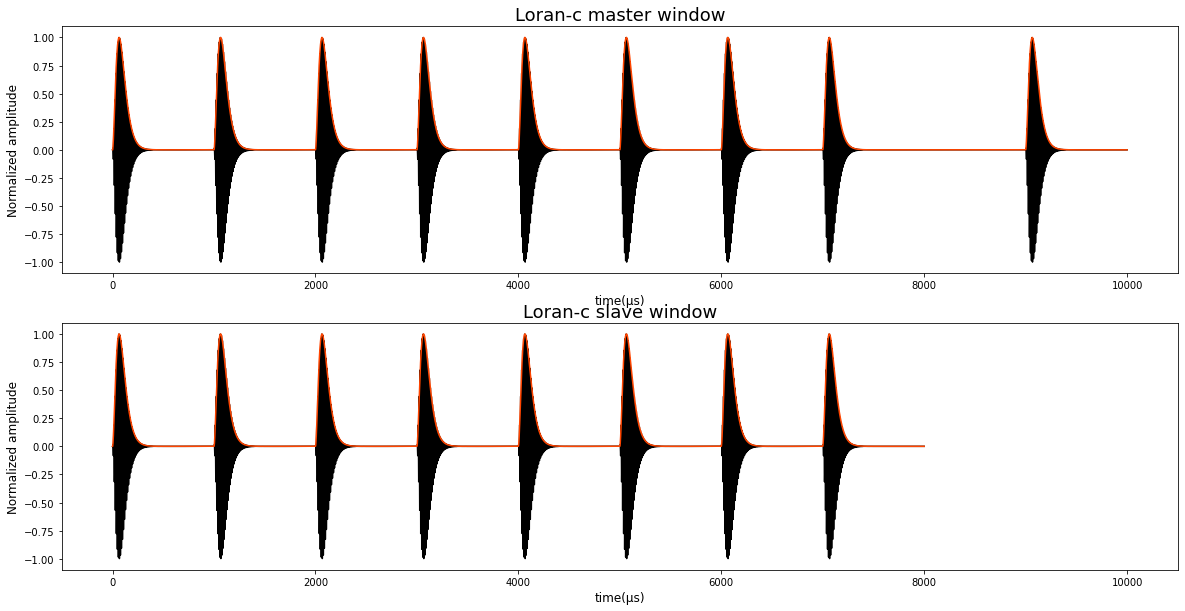

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].plot(timespace_m, master_window, 'k')
axes[0].plot(timespace_m, master_window_e, 'orangered')
axes[0].set_xlim(-500, 10500)
axes[0].set_title("Loran-c master window", fontsize=18)
axes[0].set_xlabel("time(μs)", fontsize=12)
axes[0].set_ylabel("Normalized amplitude", fontsize=12)

axes[1].plot(timespace_s, slave_window, 'k')
axes[1].plot(timespace_s, slave_window_e, 'orangered')
axes[1].set_xlim(-500, 10500)
axes[1].set_title("Loran-c slave window", fontsize=18)
axes[1].set_xlabel("time(μs)", fontsize=12)
axes[1].set_ylabel("Normalized amplitude", fontsize=12)

plt.show()

In [13]:
def merge_signal_by_id(id=0, timespace_m=0, master_window=0, master_window_e=0, timespace_s=0, slave_window=0, slave_window_e=0 ):
    
    if id==7430:
        id = '7430 China North Sea'
        sending_station = ['master_Rongcheng', 'slave_Xuancheng', 'slave_Helong']
        sending_timing = [10000, 13459.7, 30852.32]
    
    elif id==8390:
        id = '8390 China East Sea'
        sending_station = ['master_Xuancheng', 'slave_Raoping', 'slave_Rongcheng']
        sending_timing = [10000, 13795.52, 31459.70]
    
    elif id==9930:
        id = '9930 East Asia'
        sending_station = ['master_Pohang', 'slave_Kwangju', 'slave_Ussuriisk', 'slave_Incheon']
        sending_timing = [10000, 11946.97, 54162.44, 81352]
    
    else:
        print("id error occured")
        return
    
    # variables
    start_time = 0
    timespace = np.array([])
    signal = np.array([])
    signal_e = np.array([])
    #print("timspace_s size : ", len(timespace_s))
    #print("slave_window size : ", len(slave_window))
    #print("salve_window_e size : ", len(slave_window_e))
    
    for station, end_time in zip(sending_station, sending_timing):
        
        status, site = station.split('_')
        print("status, site :", status, site)
        if status=='master':
            print("master process")
            timespace = np.append(timespace, timespace_m)
            signal = np.append(signal, master_window)
            signal_e = np.append(signal_e, master_window_e)
            
            start_time = end_time
            print("length of timespace :", len(timespace), "|| length of signal :", len(signal), "|| length of signal_e :", len(signal_e))
            print("master process over; start_time :", start_time)
            print()
        
        elif status=='slave':
            print("slave process; end time :", end_time)
            time_interval = end_time-start_time
            
            temp = np.linspace(start_time, end_time, int(30*(time_interval)))
            temp_signal = np.zeros(shape=(int(30*time_interval), ))
            print("shape of temp :", temp.shape, "shape of temp_signal :", temp_signal.shape)
            
            timespace = np.append(timespace, temp[1:])
            signal = np.append(signal, temp_signal[1:])
            signal_e = np.append(signal_e, temp_signal[1:])
            
            print("length of timespace :", len(timespace), "|| length of signal :", len(signal), "|| length of signal_e :", len(signal_e))
            
            start_time = end_time
            print(start_time)            
            temp = start_time + timespace_s
            
            timespace = np.append(timespace, temp)
            signal = np.append(signal, slave_window)
            signal_e = np.append(signal_e, slave_window_e)
            
            start_time = timespace[-1]
            print("length of timespace :", len(timespace), "|| length of signal :", len(signal), "|| length of signal_e :", len(signal_e))
            print("slave process over; start_time :", start_time)
            print()
    
    plt.figure(figsize=(20, 5))
    plt.plot(timespace, signal, 'k', label='Loran-c signal')
    #plt.plot(timespace, signal, 'k')
    plt.plot(timespace, signal_e, 'orangered', label='Enveloped signal')
    #plt.plot(timespace, signal_e, 'orangered')
    plt.title('Reference signal : '+id, fontsize=17)
    plt.xlabel('time(μs)', fontsize=13)
    plt.ylabel('Normalized Amplitude', fontsize=13)
    plt.legend(loc='lower center')
    plt.show()
    
    return timespace, signal, signal_e
    

status, site : master Pohang
master process
length of timespace : 299991 || length of signal : 299991 || length of signal_e : 299991
master process over; start_time : 10000

status, site : slave Kwangju
slave process; end time : 11946.97
shape of temp : (58409,) shape of temp_signal : (58409,)
length of timespace : 358399 || length of signal : 358399 || length of signal_e : 358399
11946.97
length of timespace : 598392 || length of signal : 598392 || length of signal_e : 598392
slave process over; start_time : 19946.97

status, site : slave Ussuriisk
slave process; end time : 54162.44
shape of temp : (1026464,) shape of temp_signal : (1026464,)
length of timespace : 1624855 || length of signal : 1624855 || length of signal_e : 1624855
54162.44
length of timespace : 1864848 || length of signal : 1864848 || length of signal_e : 1864848
slave process over; start_time : 62162.44

status, site : slave Incheon
slave process; end time : 81352
shape of temp : (575686,) shape of temp_signal : (5

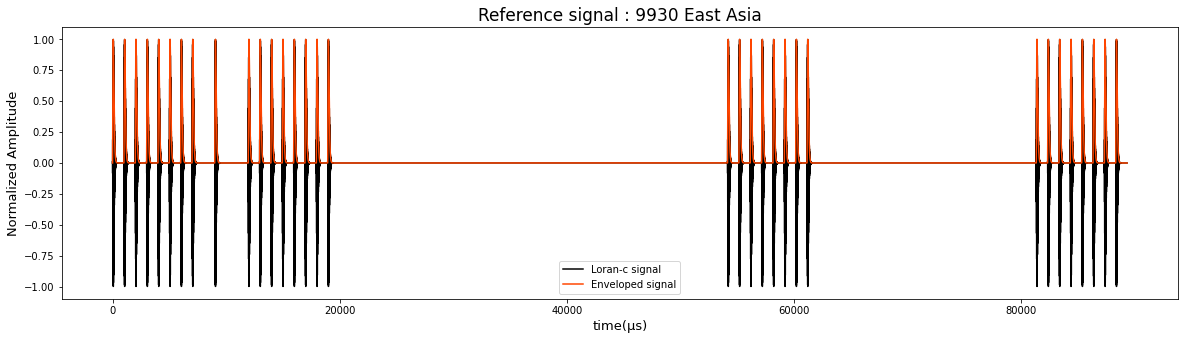

In [14]:
temp_time, temp_sginal, temp_signal_e = merge_signal_by_id(9930, timespace_m, master_window, master_window_e, timespace_s, slave_window, slave_window_e)

status, site : master Rongcheng
master process
length of timespace : 299991 || length of signal : 299991 || length of signal_e : 299991
master process over; start_time : 10000

status, site : slave Xuancheng
slave process; end time : 13459.7
shape of temp : (103791,) shape of temp_signal : (103791,)
length of timespace : 403781 || length of signal : 403781 || length of signal_e : 403781
13459.7
length of timespace : 643774 || length of signal : 643774 || length of signal_e : 643774
slave process over; start_time : 21459.7

status, site : slave Helong
slave process; end time : 30852.32
shape of temp : (281778,) shape of temp_signal : (281778,)
length of timespace : 925551 || length of signal : 925551 || length of signal_e : 925551
30852.32
length of timespace : 1165544 || length of signal : 1165544 || length of signal_e : 1165544
slave process over; start_time : 38852.32



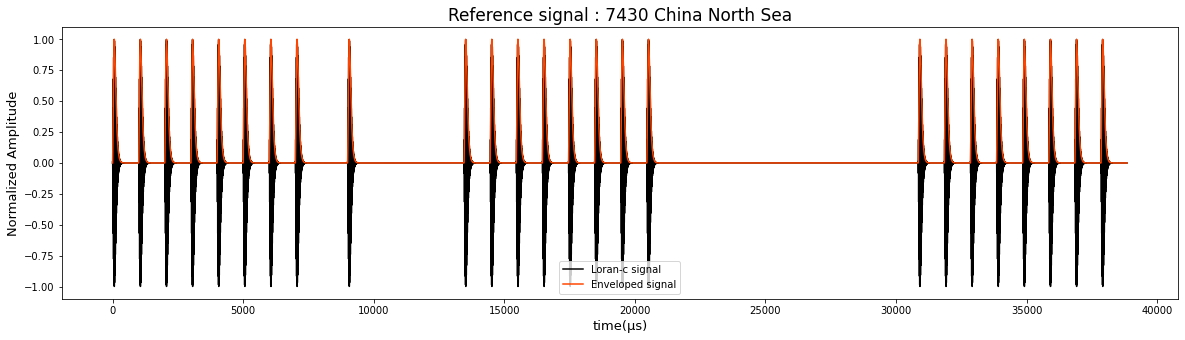

In [16]:
temp_time, temp_sginal, temp_signal_e = merge_signal_by_id(7430, timespace_m, master_window, master_window_e, timespace_s, slave_window, slave_window_e)

status, site : master Xuancheng
master process
length of timespace : 299991 || length of signal : 299991 || length of signal_e : 299991
master process over; start_time : 10000

status, site : slave Raoping
slave process; end time : 13795.52
shape of temp : (113865,) shape of temp_signal : (113865,)
length of timespace : 413855 || length of signal : 413855 || length of signal_e : 413855
13795.52
length of timespace : 653848 || length of signal : 653848 || length of signal_e : 653848
slave process over; start_time : 21795.52

status, site : slave Rongcheng
slave process; end time : 31459.7
shape of temp : (289925,) shape of temp_signal : (289925,)
length of timespace : 943772 || length of signal : 943772 || length of signal_e : 943772
31459.7
length of timespace : 1183765 || length of signal : 1183765 || length of signal_e : 1183765
slave process over; start_time : 39459.7



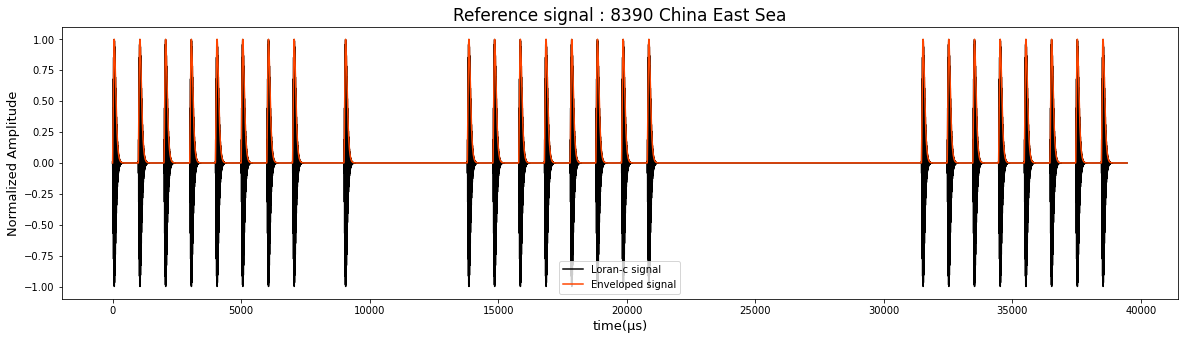

In [17]:
temp_time, temp_sginal, temp_signal_e = merge_signal_by_id(8390, timespace_m, master_window, master_window_e, timespace_s, slave_window, slave_window_e)

In [15]:
class loran_ref_signal_generator:
    
    
    def __init__():
        pass
    
    def master_window():
        pass
    
    def slave_window():
        pass
    
    def merge_signal_by_id():
        pass
    
    def auto_generator():
        pass